Train samples: 501808, test samples: 106895
train & test - done in 7s
split train & test - done in 0s
Starting LightGBM. Train shape: (501808, 122), test shape: (106895, 122)


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339253	train's l1: 0.291663	test's rmse: 0.353671	test's l1: 0.303299
[200]	train's rmse: 0.328344	train's l1: 0.28263	test's rmse: 0.35551	test's l1: 0.305294
Early stopping, best iteration is:
[1]	train's rmse: 0.352808	train's l1: 0.299808	test's rmse: 0.352057	test's l1: 0.298233
Fold  1 RMSE : 0.352057
Fold  1 MAE : 0.298233


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339599	train's l1: 0.291829	test's rmse: 0.354356	test's l1: 0.304456
[200]	train's rmse: 0.328764	train's l1: 0.2829	test's rmse: 0.355806	test's l1: 0.306144
Early stopping, best iteration is:
[1]	train's rmse: 0.352704	train's l1: 0.299606	test's rmse: 0.352928	test's l1: 0.300008
Fold  2 RMSE : 0.352928
Fold  2 MAE : 0.300008


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.33955	train's l1: 0.291832	test's rmse: 0.353939	test's l1: 0.304069
[200]	train's rmse: 0.328672	train's l1: 0.282831	test's rmse: 0.355535	test's l1: 0.305865
Early stopping, best iteration is:
[1]	train's rmse: 0.352765	train's l1: 0.299621	test's rmse: 0.352457	test's l1: 0.2994
Fold  3 RMSE : 0.352457
Fold  3 MAE : 0.299400


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339124	train's l1: 0.291431	test's rmse: 0.355347	test's l1: 0.305526
[200]	train's rmse: 0.32812	train's l1: 0.282316	test's rmse: 0.356855	test's l1: 0.307372
Early stopping, best iteration is:
[1]	train's rmse: 0.352603	train's l1: 0.299431	test's rmse: 0.353942	test's l1: 0.300916
Fold  4 RMSE : 0.353942
Fold  4 MAE : 0.300916


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.33933	train's l1: 0.291743	test's rmse: 0.35364	test's l1: 0.303699
[200]	train's rmse: 0.328525	train's l1: 0.282742	test's rmse: 0.355267	test's l1: 0.305507
Early stopping, best iteration is:
[1]	train's rmse: 0.352741	train's l1: 0.299651	test's rmse: 0.352634	test's l1: 0.299331
Fold  5 RMSE : 0.352634
Fold  5 MAE : 0.299331


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339553	train's l1: 0.291746	test's rmse: 0.354419	test's l1: 0.304819
[200]	train's rmse: 0.328659	train's l1: 0.28269	test's rmse: 0.356024	test's l1: 0.306728
Early stopping, best iteration is:
[1]	train's rmse: 0.352709	train's l1: 0.299538	test's rmse: 0.352931	test's l1: 0.299991
Fold  6 RMSE : 0.352931
Fold  6 MAE : 0.299991


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339255	train's l1: 0.291535	test's rmse: 0.355126	test's l1: 0.305275
[200]	train's rmse: 0.328758	train's l1: 0.282778	test's rmse: 0.356936	test's l1: 0.307355
Early stopping, best iteration is:
[1]	train's rmse: 0.352654	train's l1: 0.299588	test's rmse: 0.353355	test's l1: 0.300303
Fold  7 RMSE : 0.353355
Fold  7 MAE : 0.300303


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339463	train's l1: 0.291719	test's rmse: 0.353784	test's l1: 0.303841
[200]	train's rmse: 0.328758	train's l1: 0.28284	test's rmse: 0.355532	test's l1: 0.30583
Early stopping, best iteration is:
[1]	train's rmse: 0.352787	train's l1: 0.299711	test's rmse: 0.352288	test's l1: 0.299088
Fold  8 RMSE : 0.352288
Fold  8 MAE : 0.299088


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339006	train's l1: 0.291386	test's rmse: 0.355062	test's l1: 0.305138
[200]	train's rmse: 0.328139	train's l1: 0.282421	test's rmse: 0.356782	test's l1: 0.307187
Early stopping, best iteration is:
[1]	train's rmse: 0.352666	train's l1: 0.299543	test's rmse: 0.353308	test's l1: 0.300136
Fold  9 RMSE : 0.353308
Fold  9 MAE : 0.300136


/home/ubuntu/notebooks/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.339346	train's l1: 0.291591	test's rmse: 0.354629	test's l1: 0.304979
[200]	train's rmse: 0.328409	train's l1: 0.282533	test's rmse: 0.356503	test's l1: 0.307057
Early stopping, best iteration is:
[1]	train's rmse: 0.352682	train's l1: 0.299564	test's rmse: 0.353172	test's l1: 0.300283
Fold 10 RMSE : 0.353172
Fold 10 MAE : 0.300283
Run LightGBM with kfold - done in 66s
Full model run - done in 73s


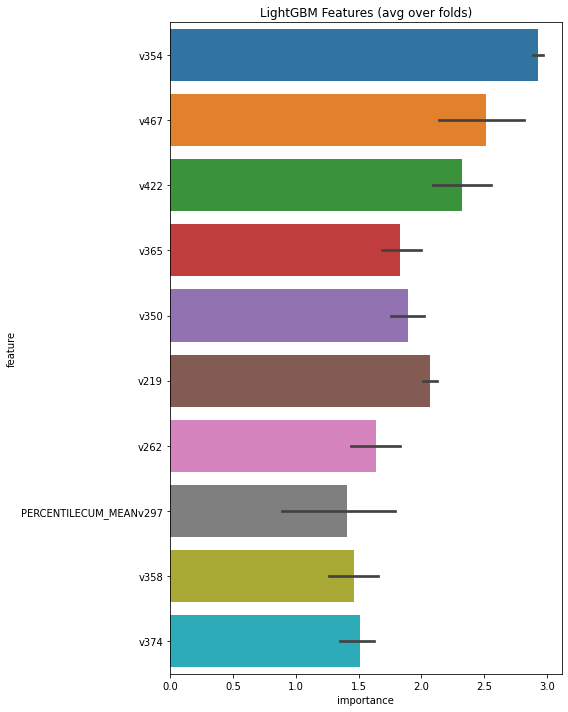

In [3]:
import gc
import re
import time
import warnings
from contextlib import contextmanager

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

FEATS_EXCLUDED = ["ROW_ID", "target"]


def main(debug=False):
    num_rows = 10_000 if debug else None
    with timer("train & test"):
        df = train_test(num_rows)
    with timer("split train & test"):
        train_df = df[df["target"].notnull()]
        test_df = df[df["target"].isnull()]
        del df
        gc.collect()
    with timer("Run LightGBM with kfold"):
        kfold_lightgbm(train_df, test_df, num_folds=10, stratified=False, debug=debug)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae(y_true, y_pred):
    return np.mean(abs(y_pred - y_true))


def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv(
        "../data/processed/fm_wo_collinear.csv", index_col=["ROW_ID"], nrows=num_rows,
    )
    test_df = pd.read_csv(
        "../data/processed/fm_test_wo_collinear.csv",
        index_col=["ROW_ID"],
        nrows=num_rows,
    )

    train_df = train_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    test_df = test_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

    print(f"Train samples: {len(train_df)}, test samples: {len(test_df)}")

    # set target as nan
    test_df["target"] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    return df


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:10]
        .index
    )
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
    plt.savefig("../reports/figures/lgbm_importances.png")


# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False):
    print(
        f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}"
    )

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(
        folds.split(train_df[feats], train_df["target"])
    ):
        train_x, train_y = (
            train_df[feats].iloc[train_idx],
            train_df["target"].iloc[train_idx],
        )
        valid_x, valid_y = (
            train_df[feats].iloc[valid_idx],
            train_df["target"].iloc[valid_idx],
        )

        # set data structure
        lgb_train = lgb.Dataset(train_x, label=train_y, free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x, label=valid_y, free_raw_data=False)

        # params optimized by hyperopt
        params = {
            "colsample_by_tree": 0.7200057909889617,
            "subsample": 0.8682562659849684,
            "is_unbalance": True,
            "learning_rate": 0.2845657674234743,
            "min_child_samples": 195,
            "num_leaves": 71,
            "reg_alpha": 0.8465888279920283,
            "reg_lambda": 0.21817506765489925,
            "subsample_for_bin": 160_000,
            "n_estimators": 10_000,
            "metric": ["rmse", "mae"],
            "n_jobs": 16,
        }

        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=["train", "test"],
            num_boost_round=10_000,
            early_stopping_rounds=200,
            verbose_eval=100,
        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += (
            reg.predict(test_df[feats], num_iteration=reg.best_iteration)
            / folds.n_splits
        )

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(
            reg.feature_importance(importance_type="gain", iteration=reg.best_iteration)
        )
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0
        )
        print(
            "Fold %2d RMSE : %.6f" % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx]))
        )
        print("Fold %2d MAE : %.6f" % (n_fold + 1, mae(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:, "target"] = sub_preds
        test_df = test_df.reset_index()
        test_df[["ROW_ID", "target"]].to_csv(submission_file_name, index=False)


if __name__ == "__main__":
    submission_file_name = "../reports/submission.csv"
    with timer("Full model run"):
        main(debug=False)
